# Lectures 9-10

In these classes we have looked at how to design and analyze algorithms for modern computers. This involves an interplay between the following elements:

- The problem we wish to solve
- The algorithm to solve the problem
- The computer that we run the algorithm on
- The model of computation used to guide the design of the algorithm and predict its runtime on a real computer

We will look at each of these elements. In this lecture there will be less code than in the past. This is because, first, I hope you have obtained enough programming maturity to understand a higher level description of something without having to code it, and secondly, coding everything presented here does become tedious.

## The problems

First, the problems. We we will largely focus on two problems: searching and sorting. The problem of searching is, given a sorted sequence of items to preprocess it so that haven a query item $x$, the report that $x$ is in the set, and if not report the largest item smaller than x (the *predecessor*) or the smallest item larger than $x$ (the *sucessor*).
I note that if you only care about exact searching, a hash table is generally the structure of choice. For sorting, this is given a collection of items, to put them in order.

Both of these problems are usually implemented in a language's standard library (though in Python, searching is not!), and I teach them not because you will need to write code to sort yourself, but understanding the techniques used for these problems is key to creating efficient algorithms and data structures for more complicated problems.

## The models of computation

The models of computation we will consider are:

- The RAM Model
- The DAM (Disk-Access) Model / External memory model
- The Cache-oblivious model

First, the RAM model. This is simply "count the operations." We use Big-O notation to express runtimes so that we don't need to get into the details, and use $n$ to represent the problem size. This is the "classical" model which is taught and used the most, and the one we have been using in the class up to this point.


# Binary search

Linear search is just lopping through the array. It takes time $O(n)$.

Binary search is the standard way to search in an ordered list/array. You simply look at the middle element, decide which way to go, and repeat. At each step it reduces the part of the array it looks at by a factor of two until it gets down to a single item. Thus the running time is the solution of $k$ in $\frac{n}{2^k}=n$ which is $O(\log n)$.

Here is some code:

In [4]:
import random

def randSortedList(size,maxgap):
    A=[0]
    for i in range(size):
        A.append(A[-1]+random.randint(1,maxgap))
    return A

In [11]:
A=randSortedList(20,10)
print(A)

[0, 1, 10, 18, 26, 27, 35, 45, 52, 60, 62, 64, 67, 71, 81, 86, 94, 99, 108, 109, 113]


In [6]:
# Finds smallest item >= searched
def linearSearch(A,x):
    for a in A:
        if x<=a:
            return a
    return None

In [12]:
print(linearSearch(A,100))

108


In [16]:
def binarySearchHelper(A,x,l,r):
    if l==r:
        return A[l]
    m=(l+r)//2
    if x<=A[m]:
        return binarySearchHelper(A,x,l,m)
    else:
        return binarySearchHelper(A,x,m+1,r)

def binarySearch(A,x):
    if x>A[-1]:
        return None
    else:
        return binarySearchHelper(A,x,0,len(A)-1)

In [15]:
print(binarySearch(A,100))   

108


In [17]:
import timeit
import matplotlib.pyplot as plt

def plotruntime(f,r,trials=1,figsize=[3,3]):
    Times=[timeit.timeit(lambda:f(n),number=trials)/trials for n in r]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(r,Times)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")
    
def plotruntimes(functions,labels,r,trials=1,figsize=[3,3]):
    fig, ax = plt.subplots(figsize=figsize)
    for f,l in zip(functions,labels):
        Times=[timeit.timeit(lambda:f(n),number=trials)/trials for n in r]
        ax.plot(r,Times,label=l)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")
    ax.set_title("Runtime plot: "+str(trials)+" trial"+("s" if trials>1 else ""))
    ax.legend()

In [18]:
A=randSortedList(100000,10)

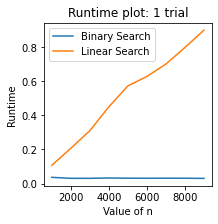

In [19]:
def searchNtimes(A,n,searchFunc):
    for i in range(n):
        x=random.randint(1,A[-1])
        searchFunc(A,x)

plotruntimes([lambda n:searchNtimes(A[:n],10000,binarySearch),lambda n:searchNtimes(A[:n],10000,linearSearch)],
            ["Binary Search","Linear Search"],range(1000,10000,1000))


# 2-4 Trees and B-Trees

One problem with binary search is that it does not allow efficient insertion and deletion, as you may need to scan through the entire array to move items.

To solve this, there have been a number of data structures that were invented in the 1960-70s, which store data in what is known as a tree. The most commonly taught and used ones are the *red-black tree* and the *AVL* tree. In this class I will taught a what is known as a 2-3 tree, and its generalization, the B-tree.

In a 2-3 tree:
- Each node has 1 or two data items stored in sorted order
- Each non-leaf node has one more child than data items (thus 2 or 3)
- All data in the leftmost child and its descendants (its *subtree*) are smaller than all data items in the node; all data items in the rightmost subtree are greater than all data items in a node; all data items in the middle subtree (if it exists) have values between the two data items in a node
- All leaves have the same depth (the tree is balanced)

This implies the hight of the tree is $O(\log n)$, and search can be done in $O(\log n)$ time by starting at the root and moving to the proper child.

To insert, we add the item to the appropriate leaf. If this causes 3 items in the node, we take the middle one and add it to the parent, splitting the node in half; if this causes the parent to have 3 items in the node, this is repeated. This takes times proportional to the height of the tree, $O(\log n)$.

Below is some code that creates 2-3 trees, and visualize them. This is probably the most longest piece of code I have presented all semester. This complication comes from the need to create the tree of nodes, using a separate node class, and maintain all the links between the nodes under insertion. There are many special cases, for the leaves, for the root, for items bigger than the biggest item in a node. In addition, the drawing takes up quite a bit of space as well.

In [20]:
from ipycanvas import Canvas

#Code for a B tree.
#Use 3 in the constructor to make 2-3 tree
#Much of this code draws the tree

class Btree:
    class node: #internal class that represents a node
        def __init__(self,data,children,parent):
            self.data=data
            self.children=children
            self.parent=parent
        def whichChild(self,x):
            for i in range(len(self.data)):
                if x<=self.data[i]:
                    return i
            return len(self.data)
        def walkToLeaf(self,x): # returns a node and index in the node
            i = self.whichChild(x)
            if len(self.data)== 0 or self.children[i]==None:
                return (self,i)
            else:
                return self.children[i].walkToLeaf(x)
        def draw(self,canvas,fromleft=0,depth=0):
            startleft=fromleft
            for i in range(len(self.children)):
                if self.children[i]!=None:
                    fromleft=self.children[i].draw(canvas,fromleft,depth+1)
                if i<len(self.data):
                    canvas.fill_text(str(self.data[i]),fromleft*30,depth*50)
                    fromleft+=1
            canvas.stroke_rect(startleft*30-15,depth*50+5,(fromleft-startleft)*30,-25)
            canvas.stroke_line( (startleft*30-15)+(fromleft-startleft)*15,
                              depth*50-20,(startleft*30-15)+(fromleft-startleft)*15,depth*50-45)
            return fromleft           
    def __init__(self,B):        
        self.root=self.node([],[None],None)
        self.B=B
    def insert(self,x):
        n,i=self.root.walkToLeaf(x)
        n.data=n.data[:i]+[x]+n.data[i:]
        n.children.append(None)
        while (n!=None and len(n.data)==self.B):
            halfB=self.B//2
            dataToPromote=n.data[halfB]
            newnodeL=self.node(n.data[:halfB],n.children[:halfB+1],n.parent)
            newnodeR=self.node(n.data[halfB+1:],n.children[halfB+1:],n.parent)
            parent=n.parent
            for nnlc in newnodeL.children:
                if nnlc:
                    nnlc.parent=newnodeL
            for nnrc in newnodeR.children:
                if nnrc:
                    nnrc.parent=newnodeR                    
            if parent!=None:
                i=parent.whichChild(dataToPromote)
                parent.data=parent.data[:i]+[dataToPromote]+parent.data[i:]
                parent.children=parent.children[:i]+[newnodeL,newnodeR]+parent.children[i+1:]
            else:
                self.root=self.node([dataToPromote],[newnodeL,newnodeR],None)
                newnodeL.parent=self.root
                newnodeR.parent=self.root
            n=parent
                
                
    def search(self,x):
        n=self.root
        if len(n.children)==0: # Empty structure
            return None
        result=None
        while n:
            i = n.whichChild(x)
            if i<len(n.data) and (result==None or n.data[i]<result):
                result=n.data[i]
            n=n.children[i]
        return result
            
    def draw(self,canvas):
        canvas.font = '18px sans-serif'
        canvas.text_align="center"
        self.root.draw(canvas,1,2)
        

In [64]:
# Run this several times
T=Btree(3) # Use 3 or higher
for i in range(20):
    T.insert(random.randint(0,99))

print(T.search(50))
        
canvas = Canvas(width=2000, height=500)
T.draw(canvas)
canvas  

62


Canvas(width=2000)

Here we look for the optimal value of $B$ experimentally. In theory it should be 1 as we are not storing the data on SSD but in RAM. But theory and practice are somewhat different. On my machine the optimal value is in the 10-50 range, with smaller and larger values being worse. When we talk about cache-oblivious algorithms we will try to describe this 

In [9]:
ToInsert=[random.randint(0,10000000) for i in range(100000) ]

def insertNrandom(B,N):
    T=twofourtree(B)
    for i in range(N):
        T.insert(ToInsert[i])
        
insertNrandom(7,10000)

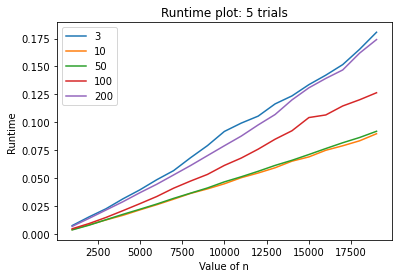

In [10]:
Bs=[3,10,50,100,200]
plotruntimes([lambda n:insertNrandom(Bs[0],n),
              lambda n:insertNrandom(Bs[1],n),
              lambda n:insertNrandom(Bs[2],n),
              lambda n:insertNrandom(Bs[3],n),
             lambda n:insertNrandom(Bs[4],n)],
            Bs,range(1000,20000,1000),5,[6,4])


# Architecture and the DAM model

At this point in the lecture, I spoke briefly about how a computer is usually thought of having three levels of memory: registers, RAM, and Disk/SSD.

- A 2.4GHz CPU does about 1 operation every 0.4ns on its registers. A CPU has about 16-32 registers.
- RAM takes about 10ns to access. Typical computers have RAM measured in GB. You lose everything in RAM when you turn off the computer. Cost is about 10,000€/TB.
- SSD takes about 10 $\mu$s to access. Typical SSDs are in the GB/small TB range. Cost is about 200€/TB. 
- Hard drives (disc) take about 10ms to access, and are in the TB range. Cost is about €20/TB.

All computers have registers, RAM and one or SSD or Hard Drive (or some combination, for example, Apple's Fusion drive combines a few TB of disc with 23-138 GB of SSD). The use of SSD is fairly new, and the price has being going down, it was not long ago that hard drives were used for everything, including tiny ones in devices like the original iPods.

As there is a huge cost to access disc, a factor for about 1 million, compared to RAM, it was realized that when working on data that does not fit into RAM, the most important thing is to mimimize the number of disc accesses. The one piece of good news is that while accessing a random memory location on disc may take 10ms, one receives not just one word of information, but one *block*, with block sizes being typically from 1000-10,000. To try to formalize this behavior, the Disc Access Model (DAM) was introduced.

**Disc Access Model**
- There is a memory of size $M$ and a disc of unlimited size.
- The disc is split into blocks of size $B$
- Transfers of one block between disc and memory take unit time
- Computation in memory is free

The main simpilfying assumption is that since disc is so much slower than CPU/memory, we don't even need to take into account the cost in memory.

The most simple example of a DAM analysis is scanning $n$ items, say to find the maximum, takes time $O(n/B)$.

Now, what about a dictionary? The 2-3 trees take time $O(\log n)$ in the DAM model for insert/delete/search, as any of these operations needs to look at the $O(\log n)$ nodes on any root-to-leaf path. There is no guarantee that these nodes are in the same block.

However, 2-3 trees can be generalized to have node sizes that are between $B/2$ and $B$, and in fact the code above allows this. Such a tree is called a B-tree, and the $B$ of the $B$ tree is chosen to be the same as the $B$ of the DAM model. In that case the height of the tree becomes $\log_B n$, which is a factor $\log B$ faster than 2-3 trees. However, in each node we need to look at all $B$ data items to decide which child to go to. In the RAM model this would cost $O(B)$ for each of the $O(\log_B n)$ nodes for a total cost of $O(B \log_B N)$, thus in the RAM model with $B=1000$, the $B$-tree would be predicted to be 100 times slower than the 2-3 tree. In the DAM, the scan of $B$ items in each node takes time $O(1)$, this the total time per operation is $O(\log_B n)$, a factor 10 faster then 2-3 trees in the DAM model. So, we have two analyses each for two different structures, which is right? The truth is that the DAM model is more accurate when your data is primarily on disc, and RAM model is often better when the data fits in memory (but there are more details to come). B-trees form the backbone of industrial databases.


## Speeding up insertion and deletion in with $B^\epsilon$ trees

In the RAM model, the insertion, deletion, and search cost of $O(\log n)$ can be shown to be the best possible if all we do is compare data items. We have seen that $O(\log_B n)$ is possible with B-trees for insertion, deletion, and search. Is this the best possible? It turns out that we can do better for insertion and deletion (we describe insertion).

This can be done with a structure often called a $B^{\epsilon}$ tree, or a buffer tree. This tree is a B-tree with the following modifications:

- The number of maximum data items (and children -1) is set to $B^{\epsilon}$ for some value of $\epsilon>0$. It helps to think of $\epsilon$ being $\frac{1}{2}$ and thus there are $\sqrt{B}$ items per node
- There is a buffer on each non-leaf node of size $B$. These items are not ordered.
- Insertions are done into the buffer of the root
- When a buffer is full the $B$ items are each placed in buffer of the appropriate child (recall that there are $B^{\epsilon}$ children).

We can assume that the buffer of the root is in memory, and thus it costs nothing to insert into it. When a buffer is full, the $B^{\epsilon}$ child buffers are loaded into memory, and each of the $B$ items is put into the appropriate child buffer. The cost is $B^{\epsilon}$ to transfer the child buffers, and thus averaged over the $B$ items being moved is $\frac{B^{\epsilon}}{B}=\frac{1}{B^{1-\epsilon}}$. As each item will be pushed down at most $\log_B n$ times before it ends up in a leaf, its total cost will be $O\left( \frac{1}{B^{1-\epsilon}} \log_B n\right)$ over its lifetime (the technical tern for this is the *amortized cost*). 

How much does this help? Lots! Imagining $\epsilon=\frac{1}{2}$ and $B=10,000$, this technique speeds up insertion in a B-tree by a factor of $\sqrt{B}=100$. 

This technique of lazy updates is a very good design technique in the DAM model: since you pay the same to deal with 1 item or B, it is best to wait until you have B items before you do anything.

# Sorting

Next, let's talk about sorting. First, the RAM model. There are many ways to sort in $O(n^2)$ time, such as repeatedly finding and removing the minimum element from a list (*selection sort*).

We discuss what is known as *merge sort*. The first observation is that two sorted lists of size $n$ can be merged in time $O(n)$. What mergesort does is to split the list in half, recursively sort each half, and then merge them. The base case is that lists of size 1 or 0 are sorted already.

The runtime is $O(n \log n)$ as each item is involved in at most $\log n$ merges.

Here is code for mergesort:

In [47]:

def merge(A,B):

    C=[]
    a=0
    b=0
    while a<len(A) and b<len(B):
        if A[a]<B[b]:
            C.append(A[a])
            a+=1
        else:
            C.append(B[b])
            b+=1
    while a<len(A):
        C.append(A[a])
        a+=1
    while b<len(B):
        C.append(B[b])
        b+=1
    return C

#Note verbose and level are just for the nice printing


def mergeSort(A,verbose=False,level=0):
    if verbose:
        print("   "*level,A)    
    if len(A)<=1:
        return A
    else:
        m=len(A)//2
        return merge(mergeSort(A[:m],verbose,level+1),mergeSort(A[m:],verbose,level+1))


In [49]:
A=[random.randrange(100) for i in range(20)]
print(A)
print(mergeSort(A))
print("Watch what happens through the recusion")
print(mergeSort(A,verbose=True))

[8, 37, 1, 94, 14, 5, 97, 36, 4, 8, 60, 45, 6, 68, 30, 39, 10, 51, 13, 4]
[1, 4, 4, 5, 6, 8, 8, 10, 13, 14, 30, 36, 37, 39, 45, 51, 60, 68, 94, 97]
Watch what happens through the recusion
 [8, 37, 1, 94, 14, 5, 97, 36, 4, 8, 60, 45, 6, 68, 30, 39, 10, 51, 13, 4]
    [8, 37, 1, 94, 14, 5, 97, 36, 4, 8]
       [8, 37, 1, 94, 14]
          [8, 37]
             [8]
             [37]
          [1, 94, 14]
             [1]
             [94, 14]
                [94]
                [14]
       [5, 97, 36, 4, 8]
          [5, 97]
             [5]
             [97]
          [36, 4, 8]
             [36]
             [4, 8]
                [4]
                [8]
    [60, 45, 6, 68, 30, 39, 10, 51, 13, 4]
       [60, 45, 6, 68, 30]
          [60, 45]
             [60]
             [45]
          [6, 68, 30]
             [6]
             [68, 30]
                [68]
                [30]
       [39, 10, 51, 13, 4]
          [39, 10]
             [39]
             [10]
          [51, 13, 4]
      

## DAM model sorting

In the DAM model, mergesort takes time $O(n \log \frac{n}{B})$. The reason is that merge is just doing three scans, of the two inputs and one output, and scans take time $\frac{n}{B}$ in the DAM model.

Can we do better? Yes! Recall that the DAM model had two parameters, $M$ and $B$. $M$ was the number of things that can fit into memory. So far we have not used memory. But here we can take advantage of it. The idea is to instead of merging two lists at a time, merge $\frac{M}{B}$ lists. That way one block from each list can be stored in memory, and the minimum item can be determined in zero time (remember that computation in memory is free). So the best thing to do is to do $\frac{M}{B}$-way mergesort: Split the list into $\frac{M}{B}$ equal-sized sublists, recursively sort each, then merge them all at once. In normal mergesort, each item is involved in $\log_2 n$ merges, but by using $\frac{M}{B}$-way mergesort, each item is in $\log_{\frac{M}{B}} n$ merges for a total runtime of $O\left( \frac{n}{N} \log_{\frac{M}{B}}n \right)$. This is a factor of $\log \frac{M}{B}$ savings. For $M=10GB$ and $B=10000$ this is $\log 10^6 \approx 20$ times faster than with binary merge.

# Homework

We will go over this next week.

1. Suppose you want to create a data structure that supports the following operations

- Insert($x$): Inserts $x$ into the structure
- Search($x$,$y$): Returns all items with keys between $x$ and $y$

    Describe (or better code) a DAM model data structure to support these two operations. Your runtime should be expressed in terms of $n$, the items in the structure; $B$, the block size; and $k$ the number of items returned by search. If search returns few items it should run faster then if it returned many.

2. Variant: Suppose search just needs to return the *number* of items between $x$ and $y$?

3. Suppose you had an unodered list of size $n$ and you wanted to compute the $k$ largest items, in sorted order. Present an algorithm, and compute the runtime in the DAM model. You can assume that $n >  M > k > B$

